In [6]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [7]:
color_list = [i for i in mcolors.TABLEAU_COLORS]
marker_list = ["o", "x"]

In [8]:
def time_converter(data):
    x = data.split('-')
    if len(x)==1:
        d = 0
        x = x[0]
    else:
        d = int(x[0])
        x = x[1]
    h,m,s = map(int,x.split(':'))
    return (d*24 + h)*60 + m + s/60

In [9]:
def memory_size_converter(size):
    num = float(size.rstrip('K'))
    return num / 1024

In [52]:
inf = open("liver_ai_job_stats.txt", "r")
data = [] 
for line2 in inf:
    line2 = line2.split("\n")[0].split(" ")
    line = [i for i in line2 if i!=""]
    if len(line)<2:
        print(line2, line)
    if line[0] == 'imgvuacr':
        data.append([line[1], line[4], time_converter(line[5]),
                     line[6], line[7], time_converter(line[8]),
                     0, 0, line[9], line[10], line[2]])
    if line[1] == 'batch':
        if line[6][-1] == 'K' and line[7][-1] == 'K':
            data[-1][6] = memory_size_converter(line[6])
            data[-1][7] = memory_size_converter(line[7])
    if line[1] == 'extern':
        if line[2] != data[-1][1]:
            if data[-1][1] != 'TIMEOUT':
                #print(data[-1][0], "extern", line[2], data[-1][1])
                data[-1][1] = line[2]
        if data[-1][6] == 0 and data[-1][7] == 0:
            data[-1][6] = memory_size_converter(line[6])
            data[-1][7] = memory_size_converter(line[7])
inf.close()
data[0]

['7106651',
 'COMPLETED',
 60.0,
 '2019-03-13T15:24:22',
 '2019-03-13T15:40:19',
 15.95,
 9999.65625,
 141.05859375,
 '1',
 '1',
 'liver_ai_+']

In [58]:
df = pd.DataFrame(data, columns=['JobID', 'State', 'Timelimit', 'Start',
                                 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize',
                                 'NNodes', 'NCPUS', 'JobName'])
df = df[df.JobName != 'test.slurm']
df['Memory'] = (df['MaxRSS'] + df['MaxVMSize']) / 1024
df.head()

,JobID,State,Timelimit,Start,End,Elapsed,MaxRSS,MaxVMSize,NNodes,NCPUS,JobName,Memory
0,7106651,COMPLETED,60.0,2019-03-13T15:24:22,2019-03-13T15:40:19,15.950000,9999.656250,141.058594,1,1,liver_ai_+,9.903042
1,7106946,COMPLETED,60.0,2019-03-13T15:48:31,2019-03-13T16:46:38,58.116667,9999.738281,141.058594,1,1,liver_ai_+,9.903122
2,7121508,COMPLETED,60.0,2019-03-14T10:31:54,2019-03-14T10:48:22,16.466667,9999.917969,141.078125,1,1,liver_ai_+,9.903316
3,7121796,COMPLETED,60.0,2019-03-14T10:55:58,2019-03-14T11:10:29,14.516667,9999.683594,141.058594,1,1,liver_ai_+,9.903069
4,7122856,COMPLETED,60.0,2019-03-14T11:53:13,2019-03-14T12:12:42,19.483333,9999.656250,141.058594,1,1,liver_ai_+,9.903042


In [54]:
df["State"].unique()

array(['COMPLETED', 'TIMEOUT', 'CANCELLED'], dtype=object)

In [55]:
print("COMPLETED jobs:", len(df[df.State=="COMPLETED"]))
print("TIMEOUT jobs:", len(df[df.State=="TIMEOUT"]))

COMPLETED jobs: 1549
TIMEOUT jobs: 421


60.0 133 133
120.0 1310 248
180.0 22 0
240.0 11 20
360.0 73 20


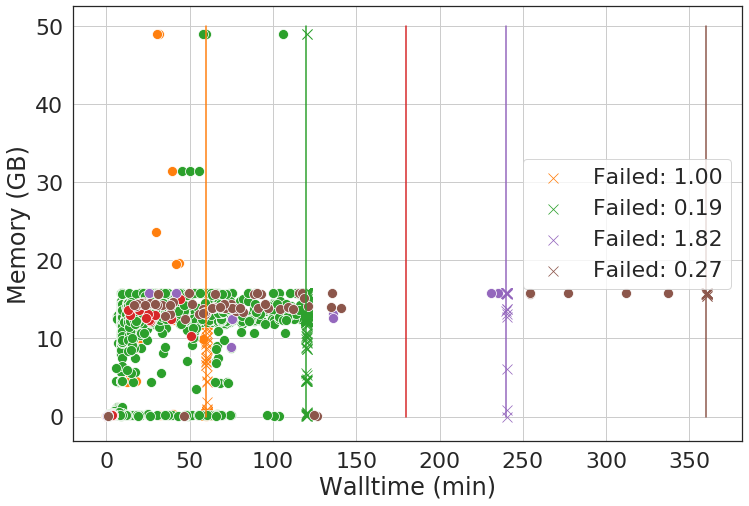

In [62]:
request = df["Timelimit"].drop_duplicates()

sns.set(font_scale=2)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12,8))

# set the request times
cnt = 1
max_color = len(color_list)
for i in request.values:
    # time in database is in min
    plt.plot([i, i], [0, 50], color=color_list[cnt])
    #plt.plot([0, i], [400, 400], color=color_list[cnt])
    sns.scatterplot(y="Memory", x="Elapsed", marker='o', s=100,
                    data=df[(df.Timelimit == i) & (df.State == "COMPLETED")],
                    color = color_list[cnt])
    len_success = len(df[(df.Timelimit == i) & (df.State == "COMPLETED")])
    len_timeout = len(df[(df.Timelimit == i) & (df.State == "TIMEOUT")])
    sns.scatterplot(y="Memory", x="Elapsed", marker='x', s=100,
                    data=df[(df.Timelimit == i) & (df.State == "TIMEOUT")],
                    color = color_list[cnt],
                    label="Failed: %.2f" %(len_timeout * 1./len_success))
    #print(i, len_success, len_timeout)
    cnt = (cnt + 1) % max_color

plt.grid(True)
ax.set_xlabel('Walltime (min)')
ax.set_ylabel('Memory (GB)')
#ax.set_xscale('log', basex=2)
#ax.set_yscale('log', basey=2)

#plt.savefig("figures/time_fail_%s.png" %(dataset), bbox_inches = 'tight')
plt.show()